In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from seaborn import histplot
from time import time
import sys  
sys.path.insert(1, '../')
from collective_posterior import CollectivePosterior
from simulators import WF, WF_wrapper, GLU, GLU_wrapper, SLCP, SLCP_wrapper
from inference_utils import get_prior

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)


model_dict = {'WF': [WF, WF_wrapper], 'GLU': [GLU, GLU_wrapper], 'SLCP': [SLCP, SLCP_wrapper]}

def get_prior_and_posterior(model):
    prior = get_prior(model)
    posterior = pickle.load(open(f'{model}/posteriors/posterior_{model}_100000_20.pkl', 'rb'))
    return prior, posterior

# Wright-Fisher

## A single observation

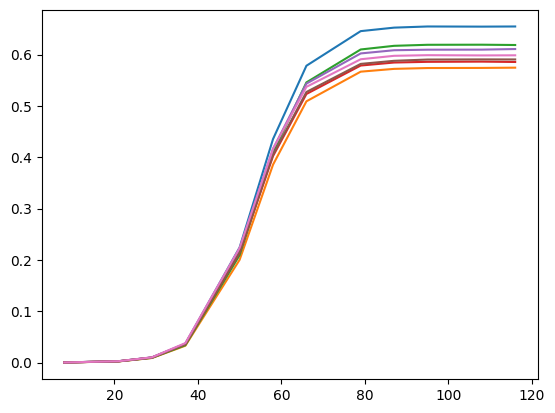

In [2]:
model = 'WF'
prior, posterior = get_prior_and_posterior(model)
simulator = model_dict[model][1]
generation = np.array(pd.read_csv('WF/empirical_data/Chuong_116_gens.txt').columns.astype('int'))

# WF parameters from Chuong et al 2024
th = torch.tensor([-0.74,-4.84,-4.32], dtype=torch.float32) # LTRΔ MAP in paper
X = simulator(parameters=th, reps=7) # 7 reps

for x in X:
    plt.plot(generation,x)

In [3]:
epsilon = -150 # also from Chuong et al
Xs = torch.tensor(X)
op = CollectivePosterior(prior, posterior, Xs, 1, epsilon)
op.get_log_C()
samples = op.sample(100)
est = samples.mean(0)
print(est)

tensor([-0.7373, -4.8533, -4.2772])


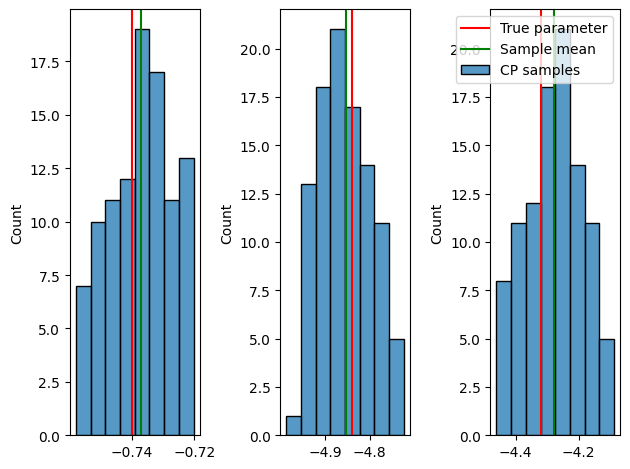

In [4]:
from seaborn import histplot

fig, ax = plt.subplots(1,len(th), tight_layout=True)
for i in range(len(th)):
    histplot(samples[:,i], ax=ax[i], label='CP samples')
    # ax[i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])
    ax[i].axvline(th[i], color='red', label='True parameter')
    ax[i].axvline(est[i], color='green', label='Sample mean')
ax[len(th)-1].legend()

In [5]:
# IG = |95% HDI| / |Prior|

post_iid = pickle.load(open('WF/posteriors/posterior_iid_WF_100000_20.pkl','rb'))
comp_x = torch.empty((10-X.shape[0], X.shape[1]))
comp_x[:,:] = torch.nan
qh, ql = 0.975, 0.025
print((samples.quantile(qh, dim=0) , samples.quantile(ql, dim=0)))
cp_ig = (samples.quantile(qh, dim=0) - samples.quantile(ql, dim=0)).prod() / (prior.base_dist.high-prior.base_dist.low).prod()
iid_samples = post_iid.set_default_x(torch.cat([X, comp_x])).sample((100,))
iid_ig = (iid_samples.quantile(qh, dim=0) - iid_samples.quantile(ql, dim=0)).prod() / (prior.base_dist.high-prior.base_dist.low).prod()

iid_ig/cp_ig

(tensor([-0.7211, -4.7319, -4.1150]), tensor([-0.7554, -4.9468, -4.4467]))


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

tensor(1881.4458)

## Evaluation on synthetic data

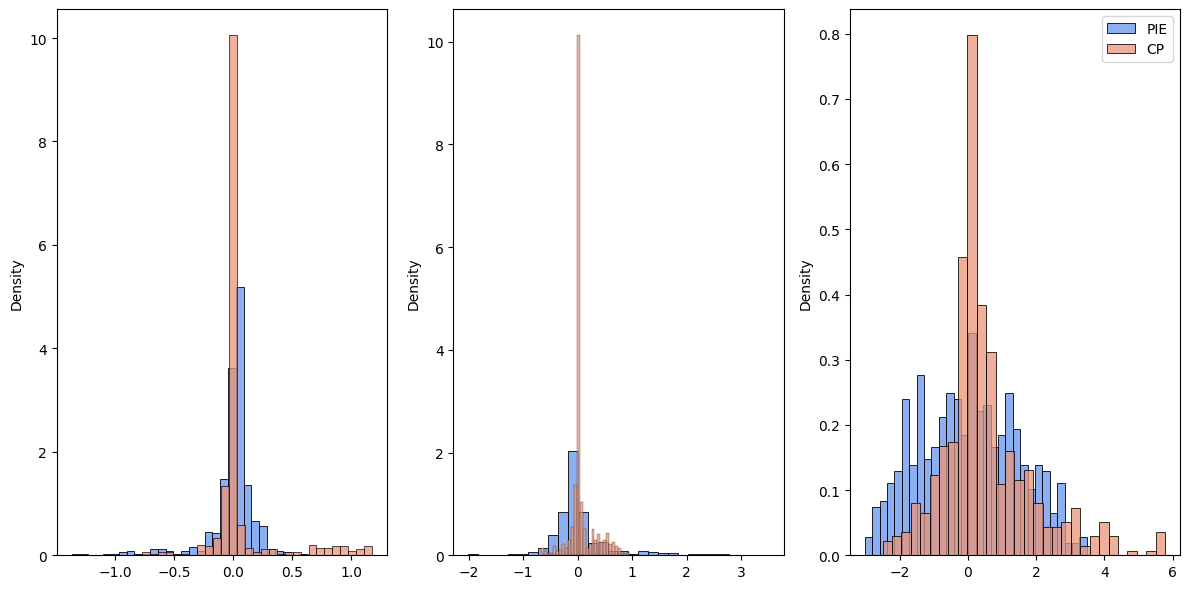

In [6]:
# Accuracy

def plot_accuracy(acc_path, ax, color, label):
    res = pd.read_csv(acc_path, index_col=0, dtype='float')
    res = torch.from_numpy(np.array(res))
    for i in range(res.shape[1]):
        histplot(res[:,i],ax=ax[i], stat='density', color=color, bins=30, label=label)
    return

n_params=len(prior.base_dist.mean)
fig, ax = plt.subplots(1,n_params, figsize=(12,6), tight_layout=True, sharex=False)

iid_acc = f'{model}/tests/accus_{model}_iid.csv'
plot_accuracy(iid_acc, ax, color='cornflowerblue', label='PIE')

cp_acc = f'{model}/tests/accus_{model}.csv'
plot_accuracy(cp_acc, ax, color='darksalmon', label='CP')
ax[-1].legend()


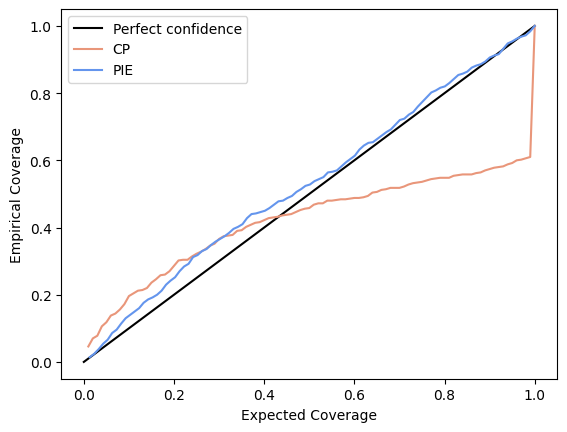

In [7]:
# Coverage

def plot_covs(covs, ax, label, color):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = label, color=color)

    ax.set_xlabel('Expected Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.legend()
    return

fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
covs = pd.read_csv(f'{model}/tests/covs_{model}.csv', index_col=0, dtype='float')
plot_covs(covs,ax,label='CP',color='darksalmon')
covs_iid = pd.read_csv(f'{model}/tests/covs_{model}_iid.csv', index_col=0, dtype='float')
plot_covs(covs_iid,ax,label='PIE',color='cornflowerblue')

# Gaussian Linear Uniform

## A single observation

tensor([-0.0676,  0.7616,  0.7990, -0.1742,  0.8043, -0.3096, -0.7161, -0.4947,
        -0.0842,  0.5725])


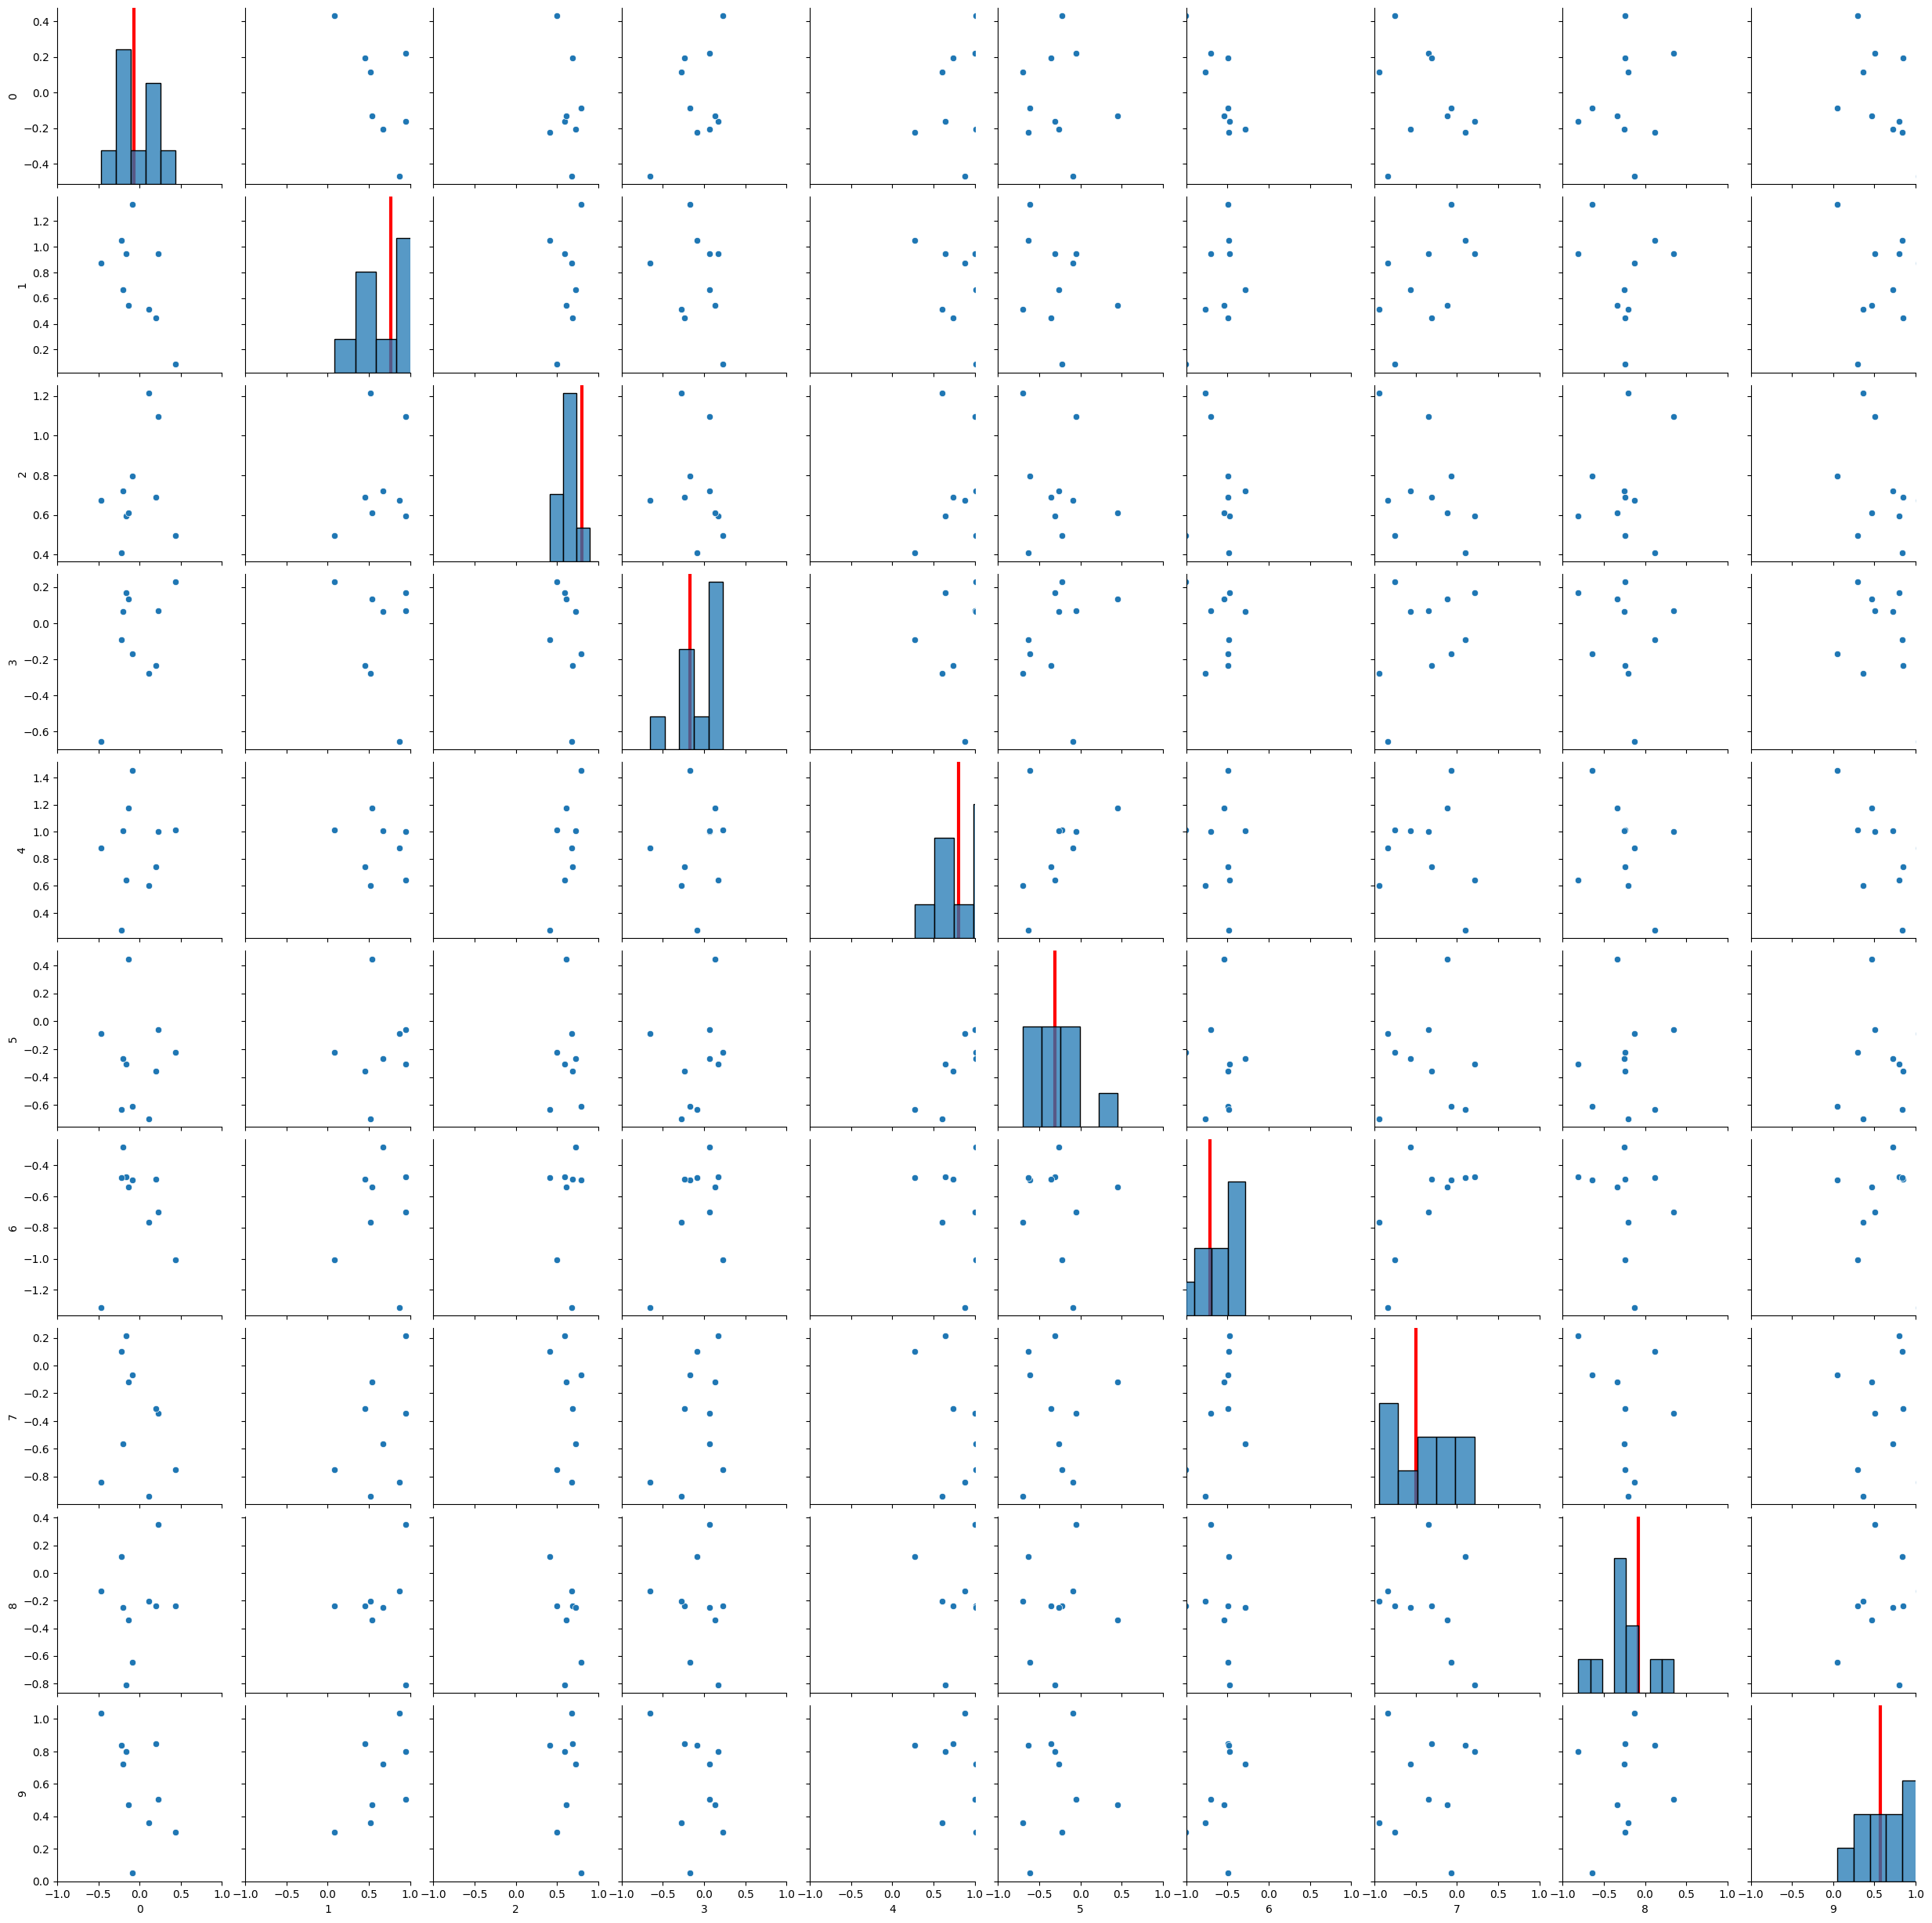

In [8]:
from seaborn import pairplot
model = 'GLU'
prior, posterior = get_prior_and_posterior(model)
simulator = model_dict[model][1]

# sample one observation
th = prior.sample((1,))[0]
print(th)
X = simulator(parameters=th, reps=10) # 10 reps

g = pairplot(pd.DataFrame(X.numpy()))
for i in range(len(th)):
    g.axes[i,i].axvline(th[i],color='red', linewidth=3)
    g.axes[i,i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])

In [9]:
epsilon = -10000 # random low number
op = CollectivePosterior(prior, posterior, X, 1, epsilon)
op.get_log_C()
samples = op.sample(100)
est = samples.mean(0)
print(est)

tensor([-0.0828,  0.7774,  0.6932, -0.1181,  0.7117, -0.1677, -0.5808, -0.2868,
        -0.2965,  0.6955])


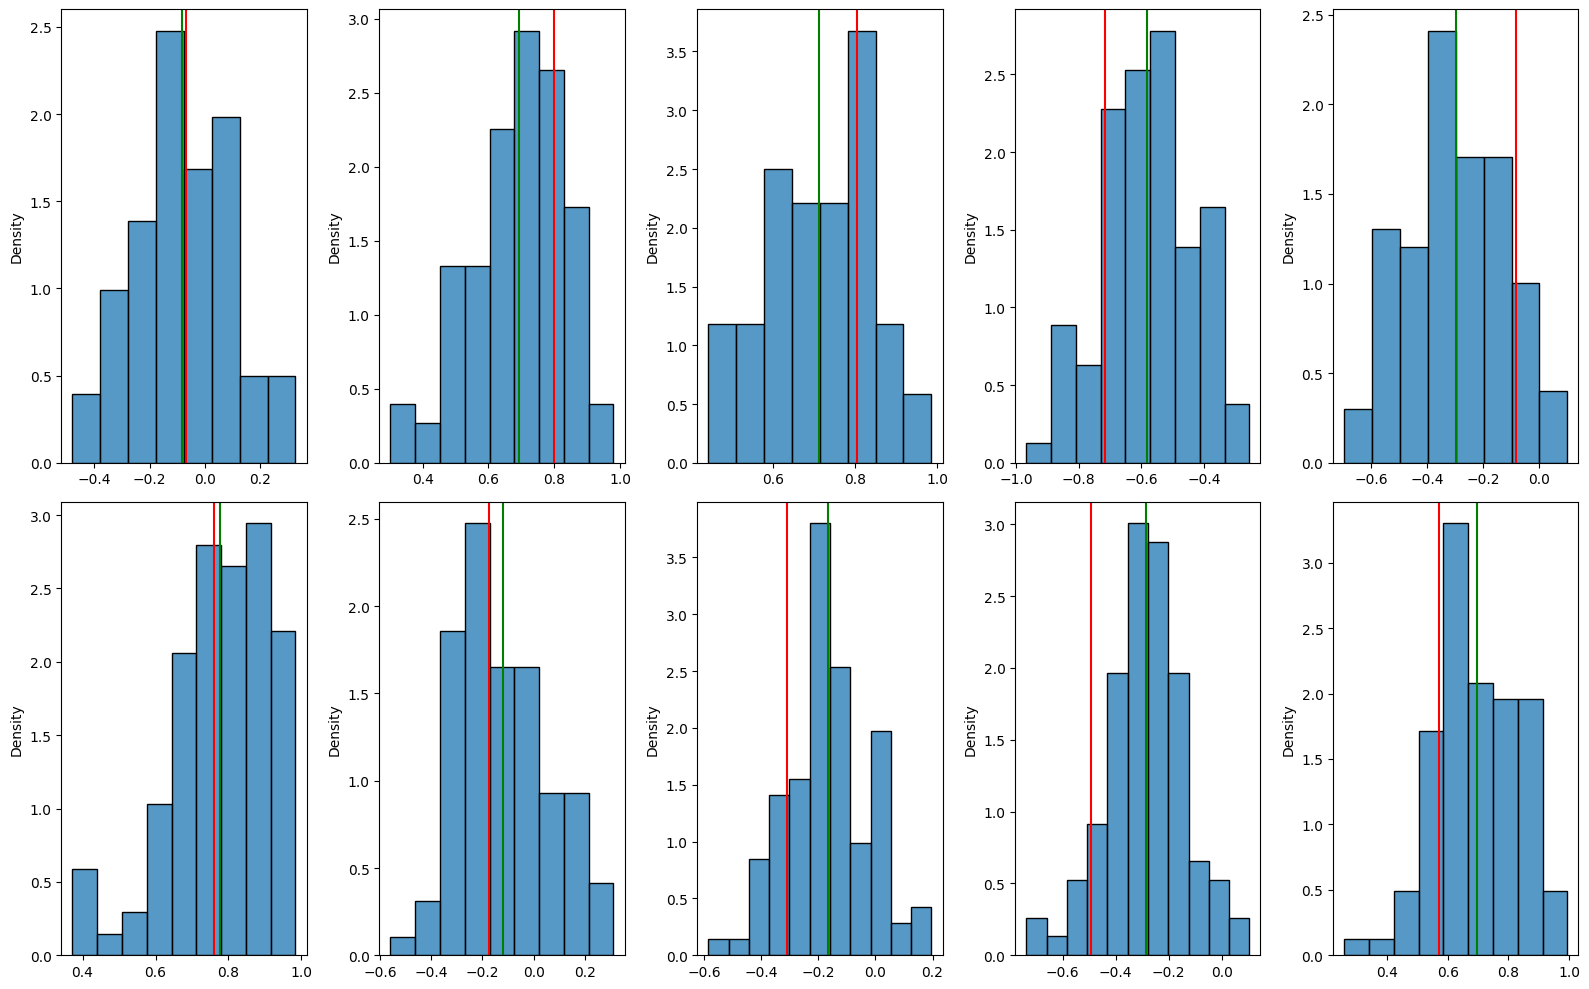

In [10]:
from seaborn import histplot

fig, ax = plt.subplots(2,5, figsize=(16,10), tight_layout=True)
for i in range(len(th)):
    j = i%2, i//2
    histplot(samples[:,i], ax=ax[j], label='CP samples', stat='density')
    # ax[i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])
    ax[j].axvline(th[i], color='red', label='True parameter')
    ax[j].axvline(est[i], color='green', label='Sample mean')


## Evaluation on synthetic observations

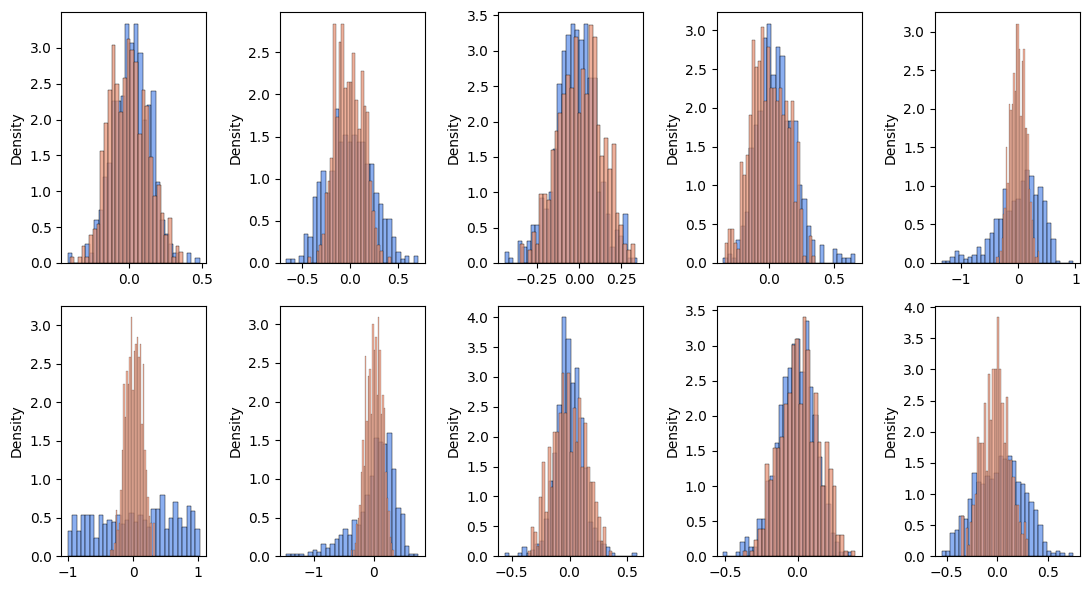

In [11]:
# Accuracy

def plot_accuracy(acc_path, ax, color):
    res = pd.read_csv(acc_path, index_col=0, dtype='float')
    res = torch.from_numpy(np.array(res))
    for i in range(res.shape[1]):
        j = i%2, i//2
        histplot(res[:,i],ax=ax[j], stat='density', color=color, bins=30)
    return

n_params=len(prior.base_dist.mean)
fig, ax = plt.subplots(2,n_params//2, figsize=(11,6), tight_layout=True, sharex=False)

iid_acc = f'{model}/tests/accus_{model}_iid.csv'
plot_accuracy(iid_acc, ax, color='cornflowerblue')

cp_acc = f'{model}/tests/accus_{model}.csv'
plot_accuracy(cp_acc, ax, color='darksalmon')

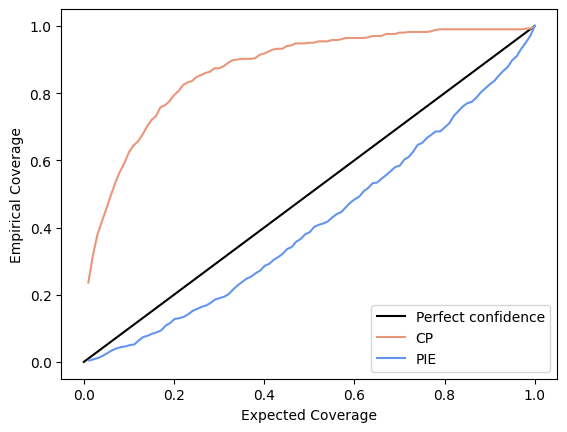

In [12]:
# Coverage

def plot_covs(covs, ax, label, color):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = label, color=color)

    ax.set_xlabel('Expected Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.legend()
    return

fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
covs = pd.read_csv(f'{model}/tests/covs_{model}.csv', index_col=0, dtype='float')
plot_covs(covs,ax,label='CP',color='darksalmon')
covs_iid = pd.read_csv(f'{model}/tests/covs_{model}_iid.csv', index_col=0, dtype='float')
plot_covs(covs_iid,ax,label='PIE',color='cornflowerblue')

## Simple Likelihood Complex Posterior (SLCP)

tensor([-0.8539, -2.1084, -0.4533, -1.1150,  2.8714])


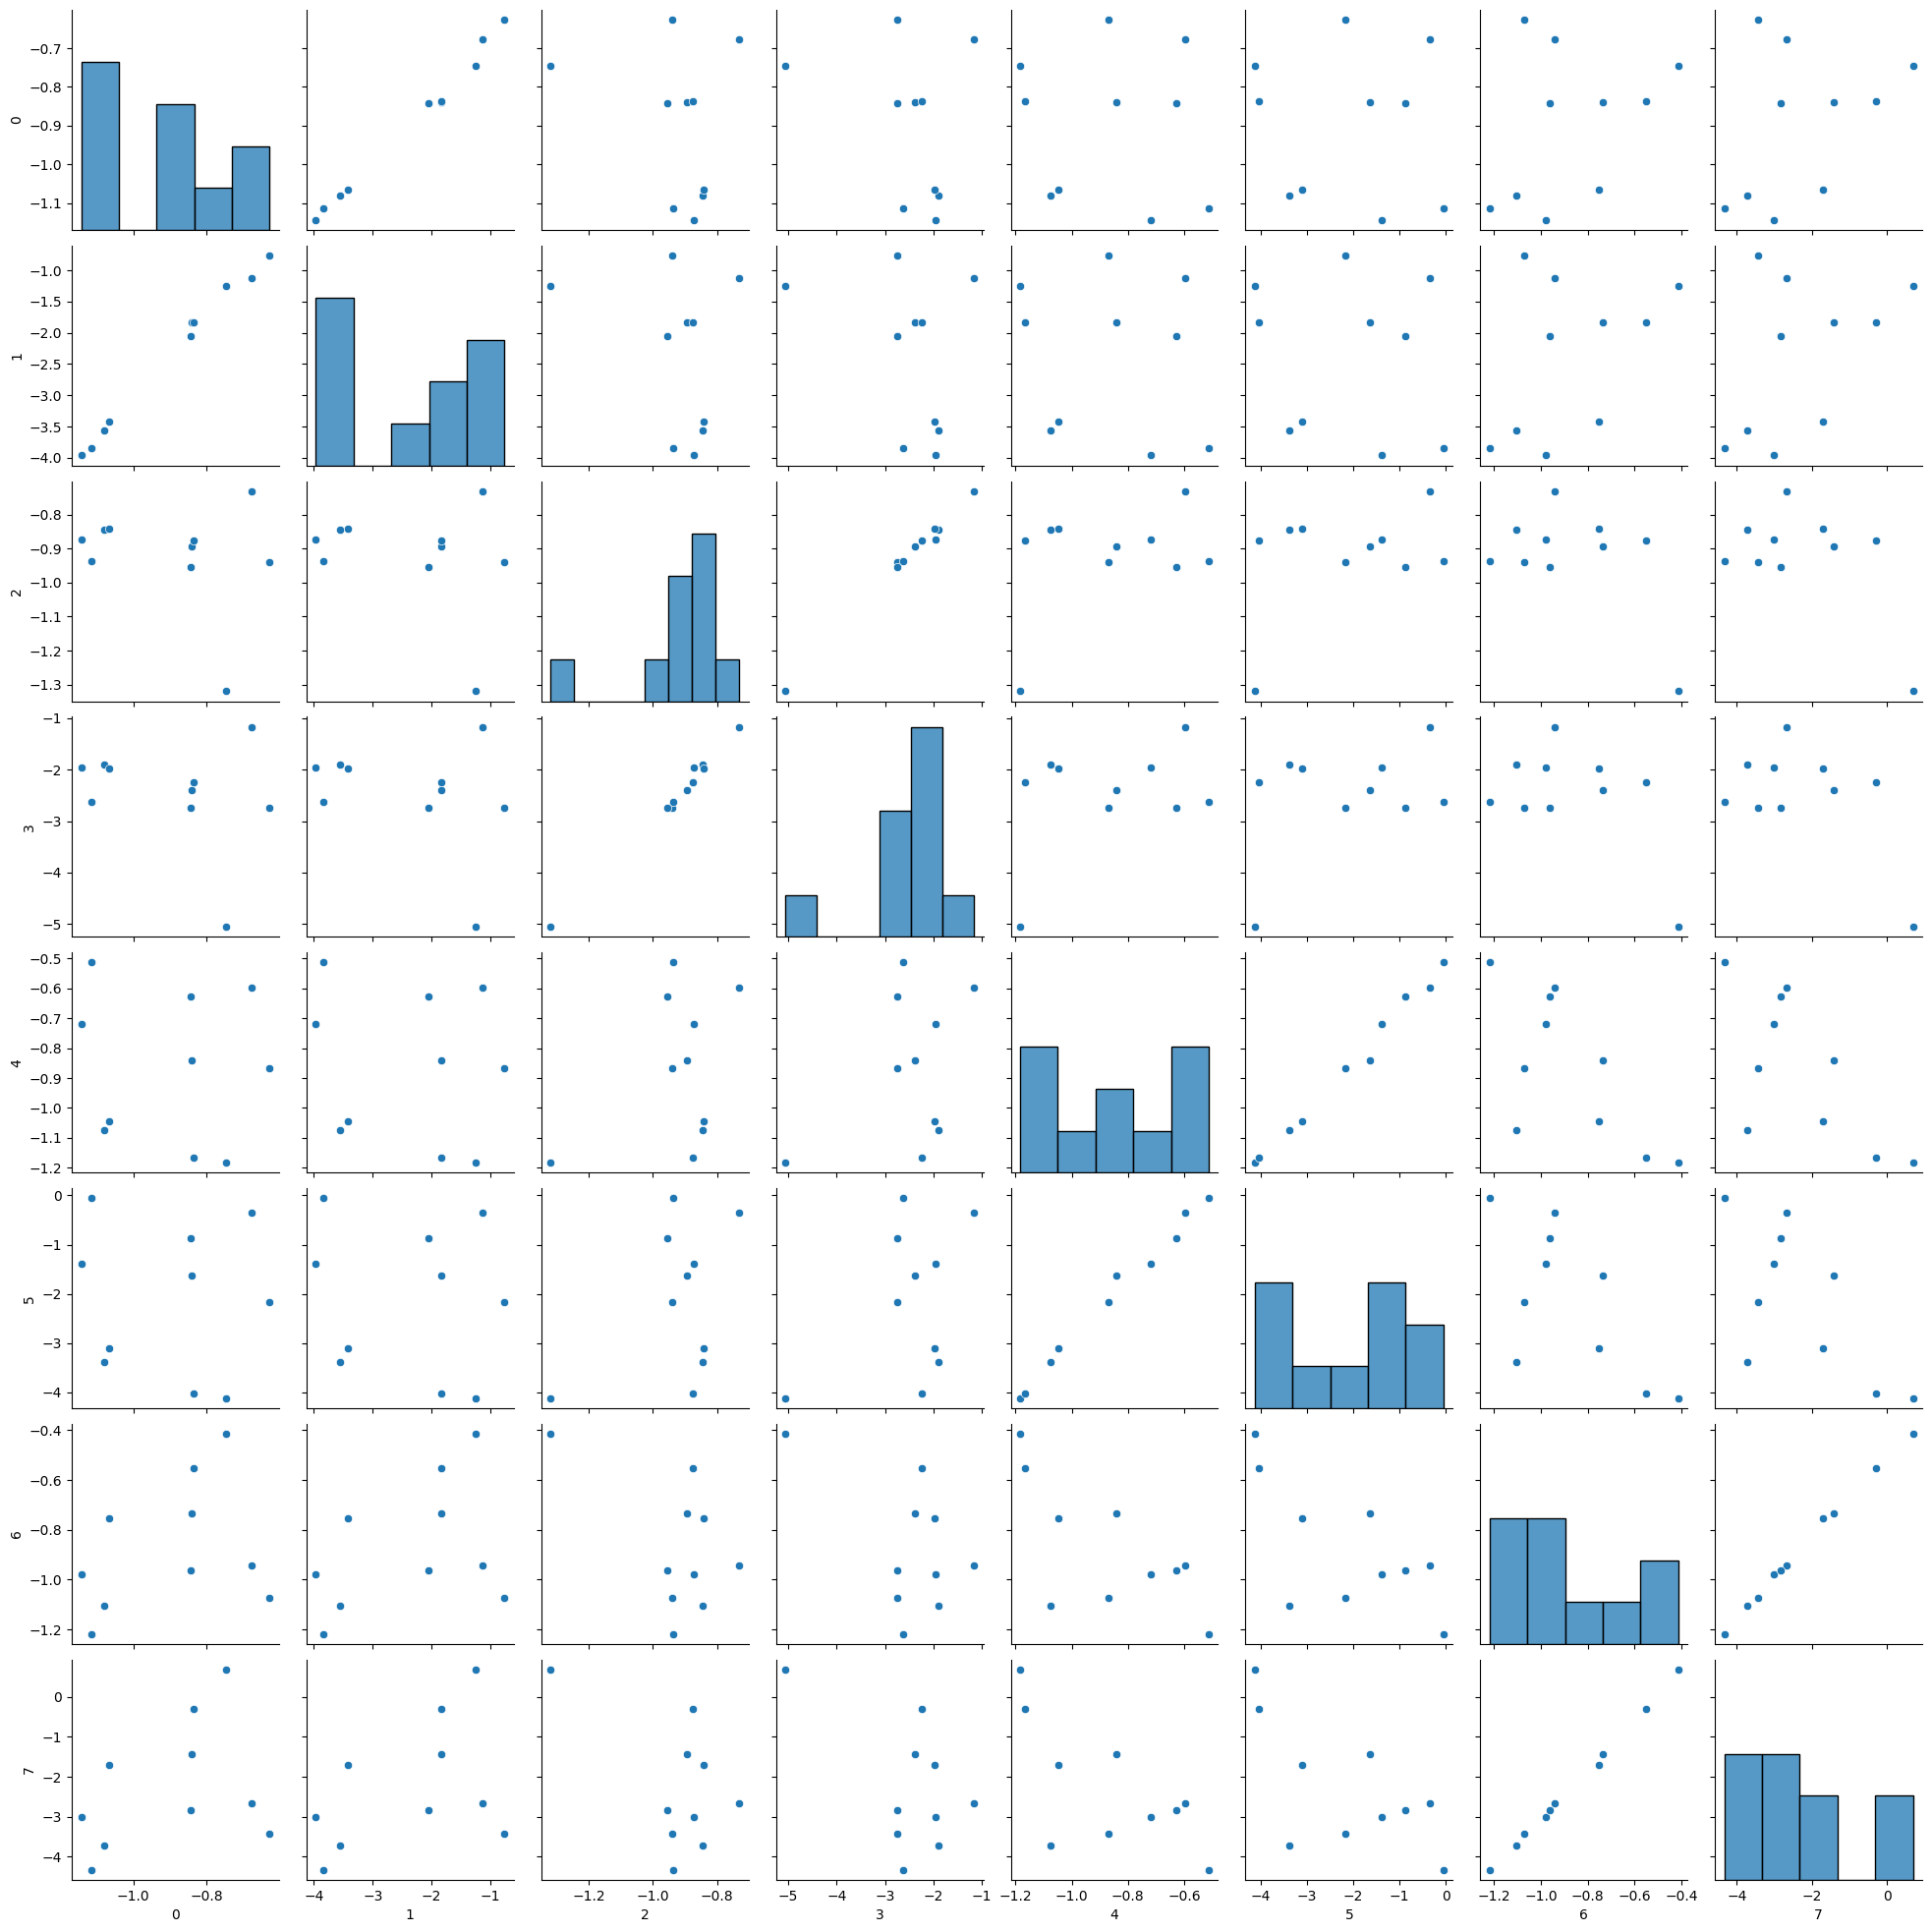

In [22]:
model = 'SLCP'
prior, posterior = get_prior_and_posterior(model)
simulator = model_dict[model][1]

# sample one observation
th = prior.sample((1,))[0]
print(th)
X = simulator(parameters=th, reps=10) # 10 reps

g = pairplot(pd.DataFrame(X.numpy()))

In [23]:
epsilon = -10000 # random low number
op = CollectivePosterior(prior, posterior, X, 1, epsilon)
op.get_log_C()
samples = op.sample(100)
est = samples.mean(0)
print(est)

tensor([-0.8783, -2.3568, -0.4698, -1.1618,  2.3211])


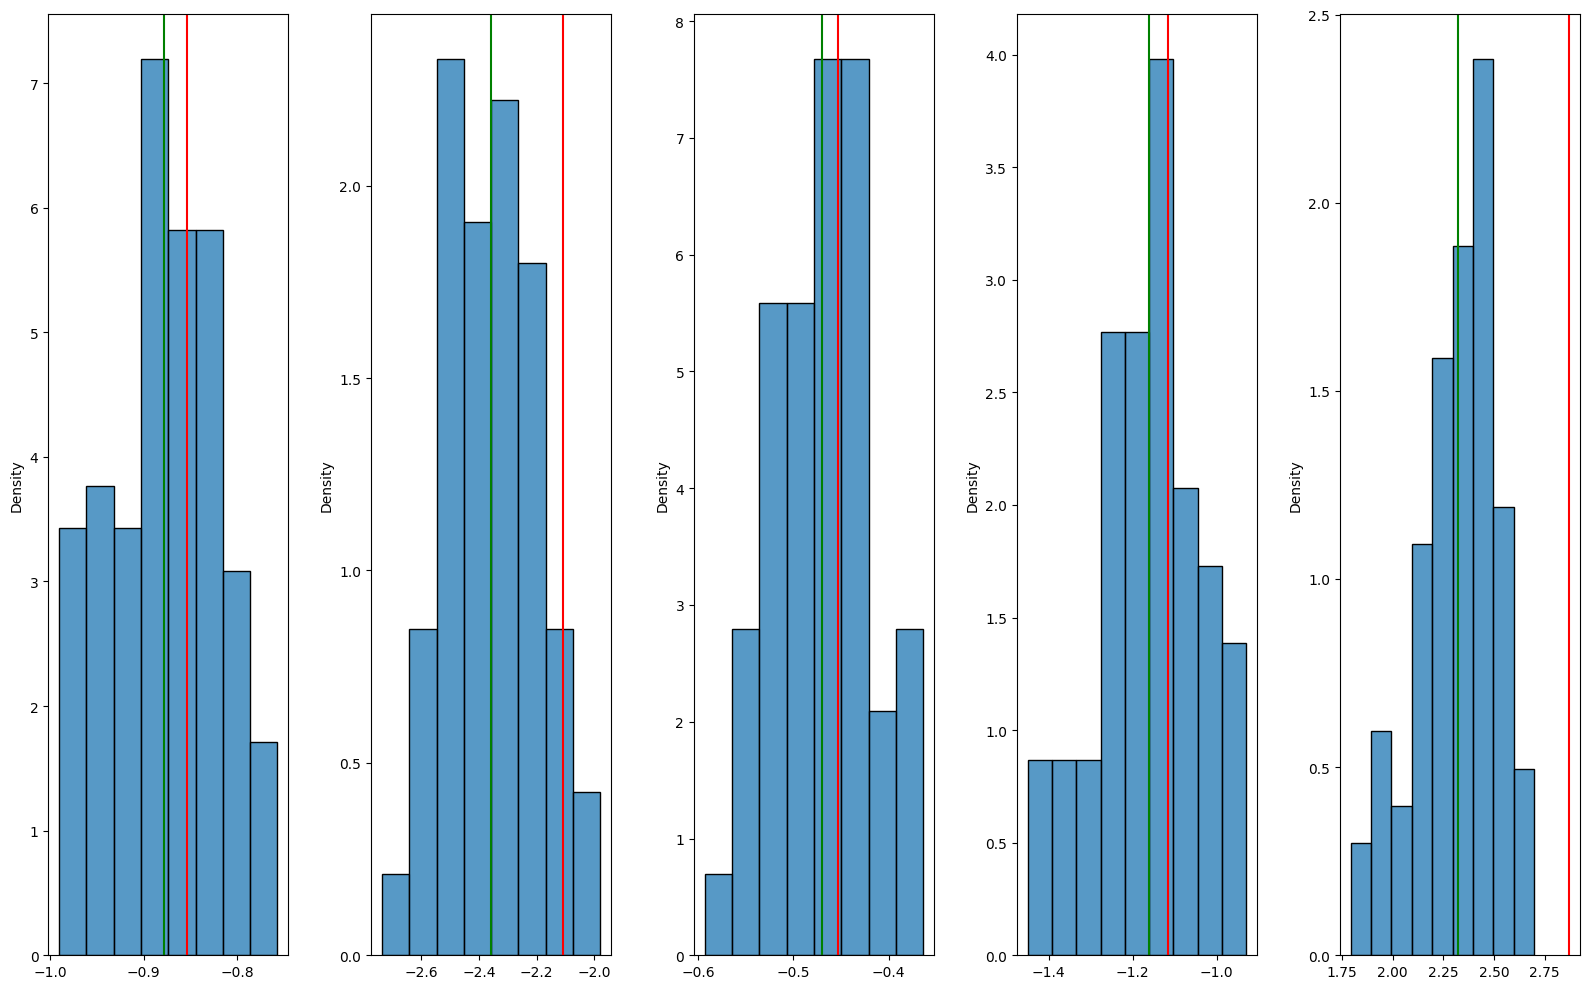

In [24]:
from seaborn import histplot

fig, ax = plt.subplots(1,5, figsize=(16,10), tight_layout=True)
for i in range(len(th)):
    histplot(samples[:,i], ax=ax[i], label='CP samples', stat='density')
    # ax[i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])
    ax[i].axvline(th[i], color='red', label='True parameter')
    ax[i].axvline(est[i], color='green', label='Sample mean')

## Evaluation on Synthetic Data

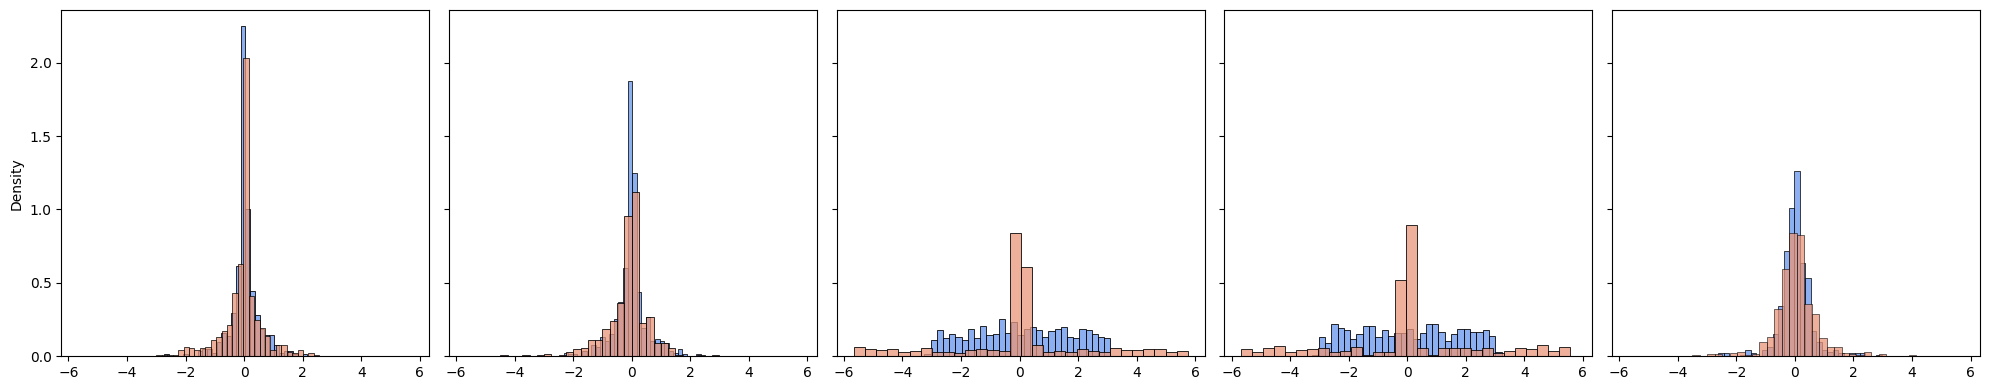

In [16]:
# Accuracy

def plot_accuracy(acc_path, ax, color):
    res = pd.read_csv(acc_path, index_col=0, dtype='float')
    res = torch.from_numpy(np.array(res))
    for i in range(res.shape[1]):
        histplot(res[:,i],ax=ax[i], stat='density', color=color, bins=30)
    return

n_params=len(prior.base_dist.mean)
fig, ax = plt.subplots(1,n_params, figsize=(20,4), tight_layout=True, sharex=True, sharey=True)

iid_acc = f'{model}/tests/accus_{model}_iid.csv'
plot_accuracy(iid_acc, ax, color='cornflowerblue')

cp_acc = f'{model}/tests/accus_{model}.csv'
plot_accuracy(cp_acc, ax, color='darksalmon')

In [17]:
res = pd.read_csv(cp_acc, index_col=0, dtype='float')
resi = pd.read_csv(iid_acc, index_col=0, dtype='float')
thresh = 0.15

X,Y = 0,0
for i in range(5):
    x = res.iloc[:,i]
    x_res = len(x[x<thresh][x>-1*thresh])/len(x)
    X+=x_res
    y = resi.iloc[:,i]
    y_res = len(y[y<thresh][y>-1*thresh])/len(y)
    Y+=y_res
    print(x_res,y_res)
X,Y

0.448 0.522
0.41 0.48
0.392 0.056
0.368 0.056
0.248 0.346


(1.8659999999999999, 1.46)

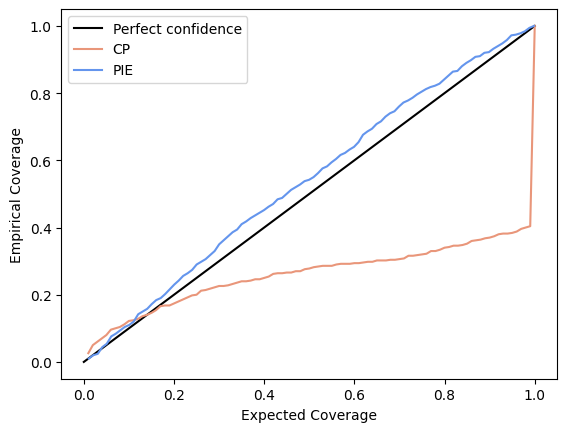

In [18]:
# Coverage

def plot_covs(covs, ax, label, color):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = label, color=color)

    ax.set_xlabel('Expected Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.legend()
    return

fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
covs = pd.read_csv(f'{model}/tests/covs_{model}.csv', index_col=0, dtype='float')
plot_covs(covs,ax,label='CP',color='darksalmon')
covs_iid = pd.read_csv(f'{model}/tests/covs_{model}_iid.csv', index_col=0, dtype='float')
plot_covs(covs_iid,ax,label='PIE',color='cornflowerblue')